In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import RD_model


dim=1
hidden=[16,64,64,16,dim]
test_x = np.linspace(0,1,1001,endpoint=True).reshape(1001,1)
test_x = torch.tensor(test_x).float()
true_f = lambda u: u*(1-u)
para_mat = np.ndarray((24,50))
nonpara_mat = np.ndarray((24,1001,50))
u_mat = np.ndarray((24,50))
settings = 0
sample_size_list = np.ndarray((24))
for ss in [8,12,16,24,32,40]:
    for ts in [5,10,20,50]:
        for i in range(50):
            checkpoints = torch.load('checkpoint_para/ckpt_rd_64_16_%d_0.100_0.003_%d_%d.pth'%(ts,ss,i))
            model_net = RD_model.NonParametricModel(state_dim=dim,hidden=hidden)
            model_net.net.load_state_dict(checkpoints['net'])
            para_mat[settings,i] = checkpoints['D'].to('cpu').detach().numpy()*1e-3
            nonpara_mat[settings,:,i:(i+1)] = (model_net.net(test_x) - true_f(test_x)).detach().numpy()
            u_mat[settings,i] = checkpoints['u_loss']
            sample_size_list[settings] = ss*ts
        settings = settings + 1
bias = np.mean(para_mat,axis=1) - 3e-3
std = np.sqrt(np.mean(np.square(para_mat - np.mean(para_mat,axis=1,keepdims=True)),axis=1))
rmse = np.sqrt(bias**2 + std**2)
bias_non = np.sqrt(np.mean(np.square(np.mean(nonpara_mat,axis=2)),axis=1))
std_non = np.sqrt(np.mean(np.square(nonpara_mat -np.mean(nonpara_mat,axis=2,keepdims=True)),axis=(1,2)))
rmse_non = np.sqrt(bias_non**2 + std_non**2)
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
print(sample_size_list)
print(rmse)
print(rmse_non)
print(rmse_u)
# np.savez('outputs/rd_para_results.npz',rmse=rmse,rmse_non=rmse_non,rmse_u=rmse_u,sample_size_list=sample_size_list)


/home/yuanyuanbenben/anaconda3/envs/nnbase/lib/python3.8/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/tmp/ipykernel_207580/1780954478.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted

[  40.   80.  160.  400.   60.  120.  240.  600.   80.  160.  320.  800.
  120.  240.  480. 1200.  160.  320.  640. 1600.  200.  400.  800. 2000.]
[0.00086854 0.00072169 0.00060857 0.00049614 0.00074496 0.00048876
 0.00053148 0.00041728 0.00076089 0.00046688 0.00046968 0.00024696
 0.00067585 0.00043464 0.00037557 0.00030421 0.00051584 0.00036625
 0.00034634 0.00019571 0.00037616 0.00036253 0.00024249 0.0002187 ]
[0.00851141 0.00721554 0.00630282 0.00432471 0.0083182  0.00603945
 0.00517266 0.00374596 0.00743795 0.00608826 0.00481418 0.00367805
 0.00592311 0.00514052 0.00401627 0.00309558 0.00563647 0.00480138
 0.0039958  0.00303503 0.00539659 0.00436391 0.00345633 0.0025685 ]
[0.00822482 0.00621531 0.00496627 0.00300884 0.00704477 0.00483356
 0.00412465 0.00280407 0.00625038 0.00482669 0.0035289  0.00232656
 0.00502829 0.00365545 0.00294573 0.00196549 0.00468259 0.00323064
 0.00268622 0.00180543 0.00405108 0.00279483 0.00233829 0.00158648]


[[-0.3066404]] [-3.58930111]
[[-0.41862531]] [-3.25811274]


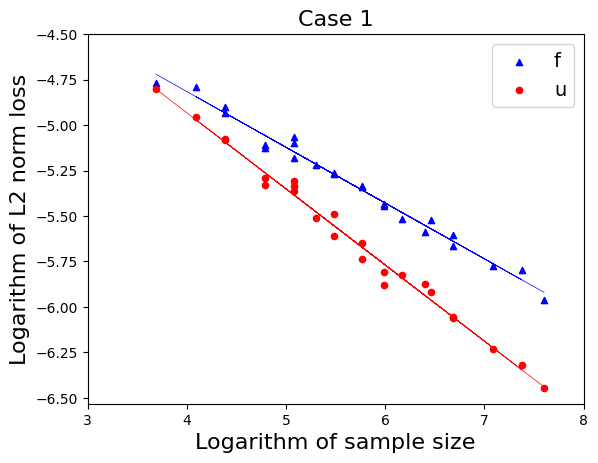

In [29]:
from sklearn.linear_model import LinearRegression
data = np.load('outputs/rd_para_results.npz')
rmse_non = data['rmse_non']
rmse_u = data['rmse_u']
sample_size_list = data['sample_size_list']
x1 = np.log(sample_size_list)
y1 = np.log(rmse_non)
regressor1 = LinearRegression()
regressor1 = regressor1.fit(np.reshape(x1,(-1, 1)),np.reshape(y1,(-1, 1)))
print(regressor1.coef_, regressor1.intercept_)  
plt.scatter(x1,y1,s=20,c='b',marker='^')
# plt.xlim((3,8))
# plt.ylim((-6,-4.5))
x2 = np.log(sample_size_list)
y2 = np.log(rmse_u)
regressor2 = LinearRegression()
regressor2 = regressor2.fit(np.reshape(x2,(-1, 1)),np.reshape(y2,(-1, 1)))
print(regressor2.coef_, regressor2.intercept_) 
plt.scatter(x2,y2,s=20,c='r')
plt.plot(np.reshape(x1,(-1,1)), regressor1.predict(np.reshape(x1,(-1,1))),'-b',linewidth=0.5)
# plt.annotate(r'slope =$%.3f$' % regressor1.coef_[0][0], c='b', xy=(6, 6*regressor1.coef_ + regressor1.intercept_),
#              xycoords='data', xytext=(+30, +30),
#              textcoords='offset points', fontsize=12,
#              arrowprops=dict(arrowstyle='->',connectionstyle="arc3,rad=0.3"))
plt.plot(np.reshape(x2,(-1,1)), regressor2.predict(np.reshape(x2,(-1,1))),'-r',linewidth=0.5)
# plt.annotate(r'slope =$%.3f$' % regressor2.coef_[0][0], c='r', xy=(5, 5*regressor2.coef_ + regressor2.intercept_),
#              xycoords='data', xytext=(-100, -50),
#              textcoords='offset points', fontsize=12,
#              arrowprops=dict(arrowstyle='->',connectionstyle="arc3,rad=0.3"))
x_tick = np.linspace(3,8,6,endpoint=True)
plt.xticks(x_tick,fontsize=10)
y_tick = np.linspace(-6.5,-4.5,9,endpoint=True)
plt.yticks(y_tick,fontsize=10)
plt.legend(['f','u'],fontsize=14)
plt.xlabel('Logarithm of sample size',fontsize=16)
plt.ylabel('Logarithm of L2 norm loss',fontsize=16)
plt.title('Case 1',fontsize=16)
plt.show()
# plt.savefig("./pic/RD_rate.png")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import RD_model


dim=1
hidden=[16,64,64,16,dim]
test_x = np.linspace(0,1,1001,endpoint=True).reshape(1001,1)
test_x = torch.tensor(test_x).float()
true_f = lambda u: u*(1-u)
para_mat = np.ndarray((1,500))
nonpara_mat = np.ndarray((1001,500))
u_mat = np.ndarray((1,500))
sigma_list = np.ndarray((1,500))
size = 0
ts = 10
ss = 16
# epo = np.ndarray((100))
for i in range(500):
    checkpoints = torch.load('checkpoint_para/ckpt_rd_64_16_%d_0.100_0.003_%d_%d.pth'%(ts,ss,i))
    model_net = RD_model.NonParametricModel(state_dim=dim,hidden=hidden)
    model_net.net.load_state_dict(checkpoints['net'])
    para_mat[:,i] = checkpoints['D'].to('cpu').detach().numpy()*1e-3
    # nonpara_mat[:,i:(i+1)] = (model_net.net(test_x) - true_f(test_x)).detach().numpy()
    # u_mat[:,i] = checkpoints['u_loss']
    checkpoints_2 = torch.load('checkpoint_para/ckpt_rd_variance_64_16_%d_0.100_0.003_%d_%d.pth'%(ts,ss,i))
    sigma_list[:,i] = np.sqrt(checkpoints['test_loss'] / 64 / ts/ ss / checkpoints_2['test_loss'])
    if np.abs(para_mat[:,i] - 3e-3) > 1.96 * sigma_list[:,i]:
        size = size + 1
    # if np.abs(para_mat[:,i] - 3e-3) > 1.645 * sigma_list[:,i]:
    #     size = size + 1
    # if np.abs(para_mat[:,i] - 3e-3) > 1.28 * sigma_list[:,i]:
    #     size = size + 1
bias = np.mean(para_mat,axis=1) - 3e-3
std = np.sqrt(np.mean(np.square(para_mat - np.mean(para_mat,axis=1)),axis=1))
rmse = np.sqrt(bias**2 + std**2)
bias_non = np.sqrt(np.mean(np.square(np.mean(nonpara_mat,axis=1))))
std_non = np.sqrt(np.mean(np.square(nonpara_mat -np.mean(nonpara_mat,axis=1,keepdims=True))))
rmse_non = np.sqrt(bias_non**2 + std_non**2)
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
std_sigma = np.mean(sigma_list)
print('bias for D:%.5fe-5'%(bias*1e5))
print('std for D:%.5fe-5'%(std*1e5))
print('rmse for D:%.5fe-5'%(rmse*1e5))
print('sigma hat:%.5fe-5'%(std_sigma*1e5))
print(size/500)
# print(epo)


/home/yuanyuanbenben/anaconda3/envs/nnbase/lib/python3.8/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/tmp/ipykernel_146859/725672890.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

bias for D:8.85737e-5
std for D:51.43312e-5
rmse for D:52.19021e-5
sigma hat:53.05964e-5
0.052


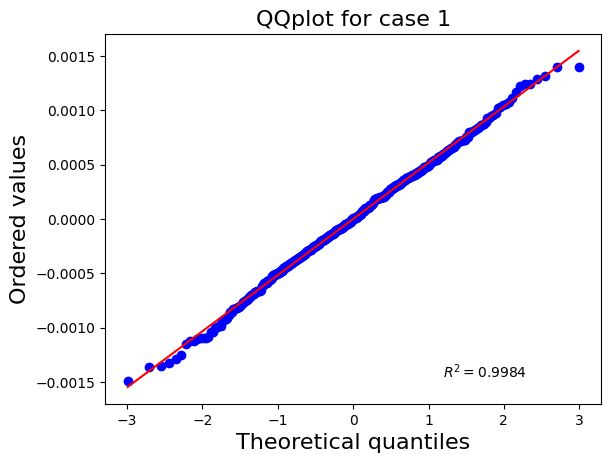

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
stats.probplot(para_mat.reshape(-1) - np.mean(para_mat.reshape(-1)), dist=stats.norm, plot=plt,rvalue=True)   
plt.title('QQplot for case 1',fontsize=16)
plt.xlabel('Theoretical quantiles',fontsize=16)
plt.ylabel('Ordered values',fontsize=16)
plt.show()
# plt.savefig('pic/RD_qqplot.png')

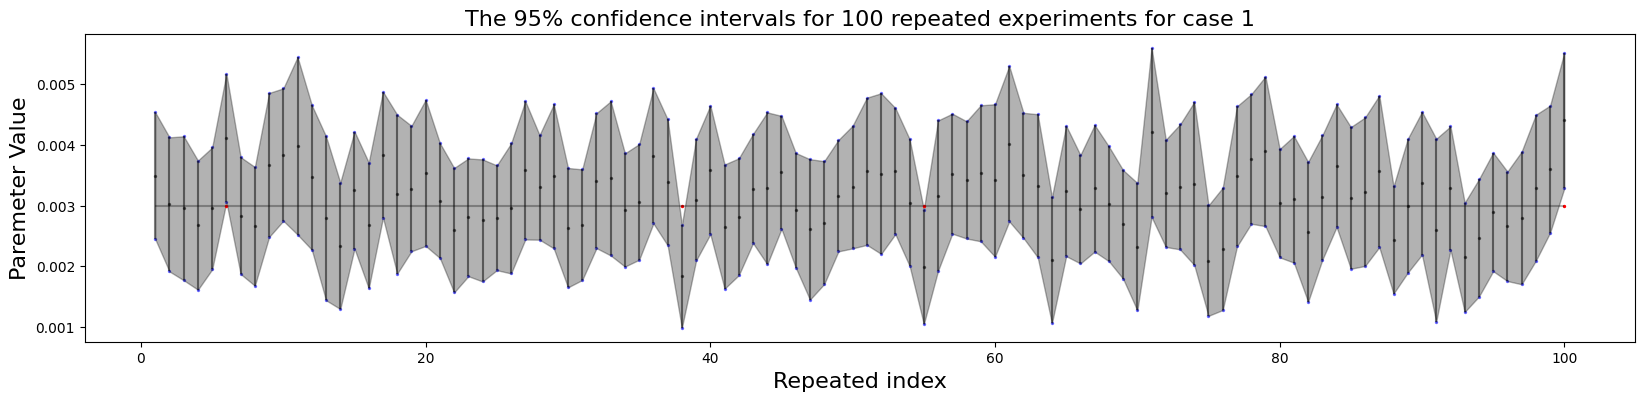

In [3]:
y = para_mat.reshape(-1)[0:100]
x = np.array(range(1,101))
theta0 = 3e-3
plt.figure(figsize=(20,4))
plt.scatter(x,y,s=2,alpha=0.5,color='black')
plt.hlines(y=theta0,xmin=1,xmax=100,linestyles='solid',colors='black',alpha=0.3)
# 90 % confidence interval
sigma = sigma_list.reshape(-1)[0:100]
# y_up_90 = y + sigma * 1.645  
# y_down_90 = y - sigma * 1.645
# plt.fill_between(x,y_down_90,y_up_90,alpha = 0.1,color = 'c')
# 80 % confidence interval
# y_up_80 = y + sigma * 1.28
# y_down_80 = y - sigma * 1.28
# plt.scatter(x,y_down_80,s=2,alpha=0.5,color='r')
# plt.scatter(x,y_up_80,s=2,alpha=0.5,color='r')
# plt.vlines(x,ymin=y_down_80,ymax = y_up_80,linestyles='solid',colors='b',alpha=0.3)
# plt.fill_between(x,y_down_80,y_up_80,alpha = 0.3,color = 'k')
# y_up_95 = y + sigma * 1.96
# y_down_95 = y - sigma * 1.96
# plt.fill_between(x,y_down_95,y_down_80,alpha = 0.5,color = 'k')
# plt.fill_between(x,y_up_80,y_up_95,alpha = 0.5,color = 'k')
y_up_95 = y + sigma * 1.96
y_down_95 = y - sigma * 1.96
plt.scatter(x,y_down_95,s=2,alpha=0.5,color='b')
plt.scatter(x,y_up_95,s=2,alpha=0.5,color='b')
plt.vlines(x,ymin=y_down_95,ymax = y_up_95,linestyles='solid',colors='k',alpha=0.5)
plt.fill_between(x,y_down_95,y_up_95,alpha = 0.3,color = 'k')
index_out = (theta0 > y_up_95) + (theta0 < y_down_95)
x_out = x[index_out]
theta0_out = np.ones_like(x_out) * theta0
plt.scatter(x_out,theta0_out,color='r',alpha=1,s=2)
plt.title('The 95% confidence intervals for 100 repeated experiments for case 1',fontsize=16)
plt.xlabel('Repeated index',fontsize=16)
plt.ylabel('Paremeter Value',fontsize=16)
plt.show()
# plt.savefig('pic/RD_confidence_interval.png')

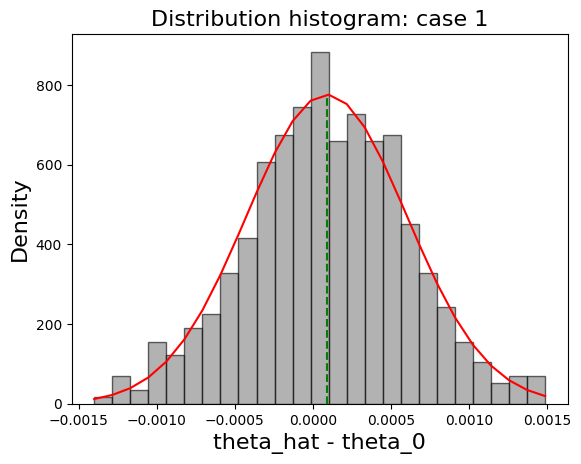

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# plt.rcParams['font.family']='Arial' 
# plt.rcParams['font.size']=15
# plt.figure(figsize=(10,7))
data = (para_mat-3e-3).reshape(-1)
# data = np.random.randn(10000)
mu =np.mean(data) 
sigma =np.std(data) 
num_bins = 25
n, bins, patches = plt.hist(data, num_bins,density=True, edgecolor="black",facecolor='gray',
                            alpha=0.6)
y = norm.pdf(bins, mu, sigma) 
plt.plot(bins, y, 'r-') 
plt.axvline(x=bias,ls="--",c="green",ymin =0,ymax=0.83)
plt.title('Distribution histogram: case 1',fontsize=16)
plt.xlabel('theta_hat - theta_0',fontsize=16) 
plt.ylabel('Density',fontsize=16) 
# plt.show()
plt.savefig('pic/RD_histogram.png')